# Semantic shift Detection with Word2Vec

In this notebook, we will use the Word2Vec model to detect semantic shifts in the meaning of words over time. We will use the `Word2VecSemanticShift` class to train the models and run the inference. We will use the `SpeakGer` corpus for this task. The dataset contains German parliament speeches published in different time periods. The task is to detect the semantic shift in the meaning of words over time, and visualize the results.

In [1]:
import pandas as pd
from ttta.methods.word2vec_semantic_shift import Word2VecSemanticShift
import nltk
from datasets import load_dataset

In [3]:
data = load_dataset("K-RLange/SpeakGer_sample")
data = data["train"].to_pandas()
data = data[data["State"] == "Nordrhein-Westfalen"]
nltk.download('stopwords')
from ttta.preprocessing.preprocess import preprocess

# Preprocessing for toy examples
data["Date"] = pd.to_datetime(data["Date"], format="mixed")
relevant_dates = [time for time, occurences in Counter(data["Date"]).items() if occurences > 100]
data = data[[data["Date"].iloc[x] in relevant_dates for x in range(len(data))]]
data["Speech"] = preprocess(data["Speech"], language="", verbose=True)  # language = "" will use default wordnet lemmatizer, faster.
# data["Speech"] = preprocess(data["Speech"], language="german", verbose=True)  # Will use Hannover POS tagger and lemmatizer, but is slower


print(data.head())

NameError: name 'load_dataset' is not defined

## Training

We will train a Word2Vec model on each period's subset of the dataset to learn the diachronic word embeddings. We will use the `Word2VecSemanticShift` class to train the models. The class takes the dataset and the target word as input and trains the Word2Vec models.

### Arguments

- `data`: The dataset containing the articles and the publication date.
- `text_column`: The column name containing the articles.
- `date_column`: The column name containing the publication date.
- `align_reference`: The reference period to align the embeddings. -1 denotes the latest time period.
- `epochs`: The number of epochs to train the Word2Vec model.
- `start_alpha`: The initial learning rate.
- `end_alpha`: The final learning rate.
- `date_format`: The date format of the publication date.

In [4]:
ss = Word2VecSemanticShift(how="D")  # Use daily chunks for this toy example

print('Before training')
print(ss.is_trained())
print(ss.get_chunks())
print(ss.get_reference(), end='\n\n')


ss.fit(data, text_column="Speech", date_column="Date", align_reference=-1, epochs=50, start_alpha=0.025, end_alpha=0.0001)

print('After training')
print(ss.is_trained())
print(ss.get_chunks())
print(ss.get_reference())

Before training
False
[]
None



NameError: name 'data' is not defined

## Saving the model

We will save the trained models using the `save` method of the `Word2VecSemanticShift` class. The method

In [5]:
ss.save("semantic_shift.pickle")
ss.load("semantic_shift.pickle")

## Updating the model

We will update the model using the `fit_update` method of the `Word2VecSemanticShift` class. The method takes the new dataset as input and updates the model. Since we don't have a new dataset, we will update the model on the same dataset.

In [6]:
ss.fit_update(data, text_column="text", date_column="date", align_reference=-1, epochs=5, start_alpha=0.025, end_alpha=0.0001)

In [5]:
print(ss.infer_vector("trump", 0, aligned=True))

ValueError: Models are not aligned. Call fit or fit_update first.

## Top-k similar words

We will use the `get_similar_words` method of the `Word2VecSemanticShift` class to get the top-k similar words to the target word. The method takes the target word and the number of similar words as input and returns the top-k similar words in the specified period using the aligned or non-aligned embeddings. The period is specified using the `chunk_index` argument.

In [15]:
ss.top_words("trump", -1, k=2, pos_tag=False, aligned=True)

(['say', 'make'], [0.9998757839202881, 0.9998600482940674])

## Visualizing the semantic shift

We will use the `visualize` method of the `Word2VecSemanticShift` class to visualize the semantic shift of the target word over time.

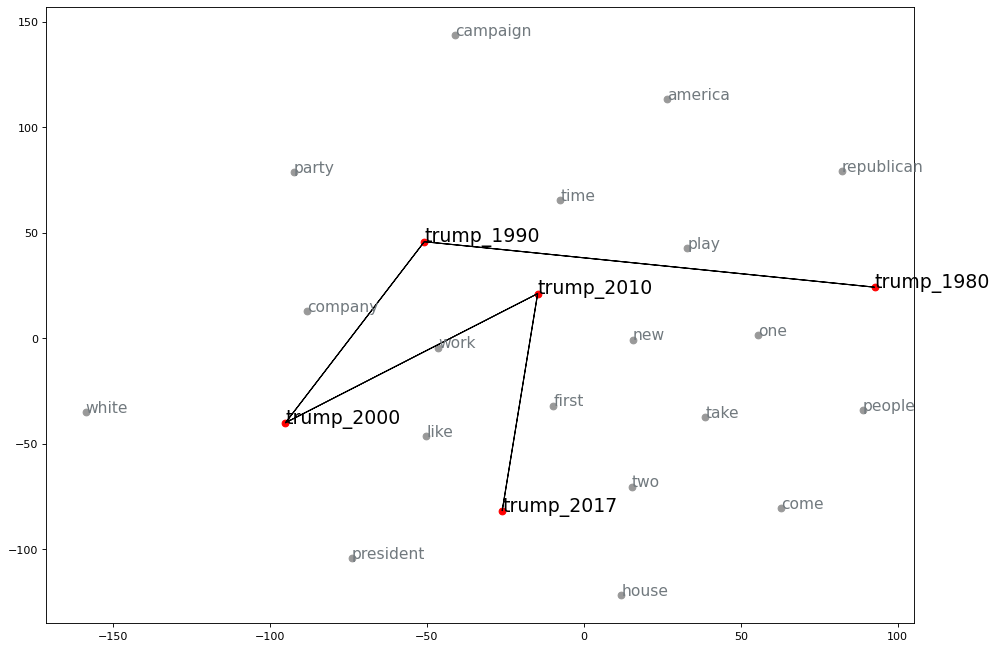

In [32]:
ss.visualize(
    main_word="trump",
    chunks_tocompare= [
        "1980",
        "1990",
        "2000",
        "2010",
        "2017"
    ],
    reference=-1,
    k = 20,
    extra_words= [
        "president",
        "campaign",
        "white",
        "house",
        "republican",
        "party",
        "america"
    ],
    ignore_words= [
        "say",
        "make",
        "would",
        "could",
        "also",
        "know",
        "want",
        "get",
        "see",
        "may",
        "show",
        "find",
        "call"
    ],
    aligned=True,
    tsne_perplexity=20
)